In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle

import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path

In [6]:
lb=LabelEncoder()
def LabelEncoding_Cat(df):
    df=df.copy()
    Cat_Var=df.select_dtypes('object').columns.tolist()
    for col in Cat_Var:
        df[col]=lb.fit_transform(df[col].astype('str'))
    return df    

def Fill_NA(df):
    df=df.copy()
    Num_Features=df.select_dtypes(['float64','int64']).columns.tolist()
    df[Num_Features]= df[Num_Features].fillna(123456789)
    return df


# Format and clean data

In [7]:
def read_csv(file_name):
    return pd.read_csv(data_path/file_name)

In [8]:
join_key = "SK_ID_CURR"

In [10]:
bureau = read_csv("bureau_balance.csv")
cred_card_bal = read_csv("credit_card_balance.csv")
pos_cash_bal = read_csv("POS_CASH_balance.csv")
prev = read_csv("previous_application.csv")

In [11]:
application_train = read_csv("application_train.csv")

In [12]:
application_test = read_csv("application_test.csv")

In [39]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
        encoder_dict[feat] = encoder

    return input_df, categorical_feats.tolist(), encoder_dict

In [40]:
def feature_engineering(app_data, bureau_df, bureau_balance_df, credit_card_df,
                        pos_cash_df, prev_app_df, install_df):
    """ Process the dataframes into a single one containing all the features """

    print('Combined train & test input shape before any merging  = {}'.format(app_data.shape))

    # Previous applications
    agg_funs = {'SK_ID_CURR': 'count', 'AMT_CREDIT': 'sum'}
    prev_apps = prev_app_df.groupby('SK_ID_CURR').agg(agg_funs)
    prev_apps.columns = ['PREV APP COUNT', 'TOTAL PREV LOAN AMT']
    merged_df = app_data.merge(prev_apps, left_on='SK_ID_CURR', right_index=True, how='left')

    # Average the rest of the previous app data
    prev_apps_avg = prev_app_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(prev_apps_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_PAVG'])
    print('Shape after merging with previous apps num data = {}'.format(merged_df.shape))
    # Previous app categorical features
    prev_app_df, cat_feats, _ = process_dataframe(prev_app_df)
    prev_apps_cat_avg = prev_app_df[cat_feats + ['SK_ID_CURR']].groupby('SK_ID_CURR')\
                             .agg({k: lambda x: str(x.mode().iloc[0]) for k in cat_feats})
    merged_df = merged_df.merge(prev_apps_cat_avg, left_on='SK_ID_CURR', right_index=True,
                            how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with previous apps cat data = {}'.format(merged_df.shape))

    # Credit card data - numerical features
    wm = lambda x: np.average(x, weights=-1/credit_card_df.loc[x.index, 'MONTHS_BALANCE'])
    credit_card_avgs = credit_card_df.groupby('SK_ID_CURR').agg(wm)   
    merged_df = merged_df.merge(credit_card_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CCAVG'])
    # Credit card data - categorical features
    most_recent_index = credit_card_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = credit_card_df.columns[credit_card_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(credit_card_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CCAVG'])
    print('Shape after merging with credit card data = {}'.format(merged_df.shape))

    # Credit bureau data - numerical features
    credit_bureau_avgs = bureau_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(credit_bureau_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with credit bureau data = {}'.format(merged_df.shape))
    
    # Bureau balance data
    most_recent_index = bureau_balance_df.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
    bureau_balance_df = bureau_balance_df.loc[most_recent_index, :]
    merged_df = merged_df.merge(bureau_balance_df, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU',
                            how='left', suffixes=['', '_B_B'])
    print('Shape after merging with bureau balance data = {}'.format(merged_df.shape))

    # Pos cash data - weight values by recency when averaging
    wm = lambda x: np.average(x, weights=-1/pos_cash_df.loc[x.index, 'MONTHS_BALANCE'])
    f = {'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm}
    cash_avg = pos_cash_df.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                                                 'SK_DPD', 'SK_DPD_DEF'].agg(f)
    merged_df = merged_df.merge(cash_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CAVG'])
    # Pos cash data data - categorical features
    most_recent_index = pos_cash_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = pos_cash_df.columns[pos_cash_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(pos_cash_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CAVG'])
    print('Shape after merging with pos cash data = {}'.format(merged_df.shape))

    # Installments data
    ins_avg = install_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(ins_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_IAVG'])
    print('Shape after merging with installments data = {}'.format(merged_df.shape))
    
    # Add more value counts
    merged_df = merged_df.merge(pd.DataFrame(bureau_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_BUREAU'])
    merged_df = merged_df.merge(pd.DataFrame(credit_card_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_CRED_CARD'])
    merged_df = merged_df.merge(pd.DataFrame(pos_cash_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_POS_CASH'])
    merged_df = merged_df.merge(pd.DataFrame(install_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_INSTALL'])
    print('Shape after merging with counts data = {}'.format(merged_df.shape))

    return merged_df

In [31]:
!ls data

application_test.csv		    installments_payments.csv
application_train.csv		    models
bureau_balance.csv		    POS_CASH_balance.csv
bureau.csv			    previous_application.csv
credit_card_balance.csv		    sample_submission.csv
HomeCredit_columns_description.csv  tmp


In [41]:
cred_card_bal = read_csv("credit_card_balance.csv")
pos_cash_bal = read_csv("POS_CASH_balance.csv")
prev = read_csv("previous_application.csv")

In [35]:
bureau_bal = read_csv("bureau_balance.csv")

In [33]:
install = read_csv("installments_payments.csv")

In [34]:
bureau = read_csv("bureau.csv")

In [ ]:
len_train = len(application_train)
app_both = pd.concat([application_train, application_test])
merged_df = feature_engineering(app_both, bureau, bureau_bal, cred_card_bal,
                                pos_cash_bal, prev, install)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


Combined train & test input shape before any merging  = (356255, 122)
Shape after merging with previous apps num data = (356255, 144)
Shape after merging with previous apps cat data = (356255, 160)
Shape after merging with credit card data = (356255, 182)
Shape after merging with credit bureau data = (356255, 195)


In [ ]:
merged_df.to_feather(f'{PATH}merged_df')

In [92]:
merged_df = pd.read_feather(f'{PATH}merged_df')

In [48]:
len(list(merged_df.columns))

213

In [107]:
f = merged_df.dtypes[0]

In [108]:
f

dtype('float64')

In [110]:
groups = merged_df.columns.to_series().groupby(merged_df.dtypes).groups

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_FAM_MEMBERS',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_AVG',
 'LIVINGARE

In [113]:
int_key, float_key, object_key = groups.keys()

In [119]:
cat = list(groups[int_key])

In [120]:
contin = list(groups[float_key])

In [121]:
cat += list(groups[object_key])

In [123]:
contin

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_FAM_MEMBERS',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_AVG',
 'LIVINGARE

In [122]:
cat

['CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_MOBIL',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'HOUR_APPR_PROCESS_START',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'SK_ID_CURR',
 'CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TY

In [140]:
cat_vars = [
 'CNT_CHILDREN',
 'FLAG_CONT_MOBILE','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_EMAIL','FLAG_EMP_PHONE',
 'FLAG_MOBIL','FLAG_PHONE','FLAG_WORK_PHONE','HOUR_APPR_PROCESS_START',
 'LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','CODE_GENDER',
 'EMERGENCYSTATE_MODE','FLAG_OWN_CAR','FLAG_OWN_REALTY','FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE','NAME_CONTRACT_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE','NAME_INCOME_TYPE','NAME_TYPE_SUITE','OCCUPATION_TYPE',
 'ORGANIZATION_TYPE','WALLSMATERIAL_MODE','WEEKDAY_APPR_PROCESS_START',
 'NAME_CONTRACT_TYPE_BAVG','WEEKDAY_APPR_PROCESS_START_BAVG','FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE','NAME_CONTRACT_STATUS','NAME_PAYMENT_TYPE','CODE_REJECT_REASON',
 'NAME_TYPE_SUITE_BAVG','NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY','NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE','CHANNEL_TYPE','NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP','PRODUCT_COMBINATION',
 'NAME_CONTRACT_STATUS_CCAVG','STATUS','NAME_CONTRACT_STATUS_CAVG'
]
contin_vars = [
    'AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','AMT_INCOME_TOTAL', 'DAYS_BIRTH', 
    'DAYS_EMPLOYED','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_HOUR',
    'DAYS_ID_PUBLISH','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_YEAR',
    'APARTMENTS_AVG','APARTMENTS_MEDI','APARTMENTS_MODE','BASEMENTAREA_AVG',
    'BASEMENTAREA_MEDI','BASEMENTAREA_MODE','CNT_FAM_MEMBERS','COMMONAREA_AVG',
    'COMMONAREA_MEDI','COMMONAREA_MODE','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION',
    'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','ELEVATORS_AVG',
    'ELEVATORS_MEDI','ELEVATORS_MODE','ENTRANCES_AVG','ENTRANCES_MEDI','ENTRANCES_MODE',
    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLOORSMAX_AVG','FLOORSMAX_MEDI',
    'FLOORSMAX_MODE','FLOORSMIN_AVG','FLOORSMIN_MEDI','FLOORSMIN_MODE','LANDAREA_AVG',
    'LANDAREA_MEDI','LANDAREA_MODE','LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI',
    'LIVINGAPARTMENTS_MODE','LIVINGAREA_AVG','LIVINGAREA_MEDI','LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_AVG','NONLIVINGAREA_MEDI','NONLIVINGAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE','OWN_CAR_AGE','REGION_POPULATION_RELATIVE','TARGET',
    'TOTALAREA_MODE','YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_MODE',
    'PREV APP COUNT','TOTAL PREV LOAN AMT','SK_ID_PREV','AMT_ANNUITY_PAVG','AMT_APPLICATION',
    'AMT_CREDIT_PAVG','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE_PAVG','HOUR_APPR_PROCESS_START_PAVG',
    'NFLAG_LAST_APPL_IN_DAY','RATE_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED',
    'DAYS_DECISION','SELLERPLACE_AREA','CNT_PAYMENT','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE',
    'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL',
    'SK_ID_PREV_CCAVG','MONTHS_BALANCE','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_DRAWINGS_ATM_CURRENT',
    'AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT',
    'AMT_INST_MIN_REGULARITY','AMT_PAYMENT_CURRENT','AMT_PAYMENT_TOTAL_CURRENT',
    'AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','CNT_DRAWINGS_ATM_CURRENT',
    'CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_POS_CURRENT',
    'CNT_INSTALMENT_MATURE_CUM','SK_DPD','SK_DPD_DEF','SK_ID_BUREAU','DAYS_CREDIT',
    'CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE',
    'CNT_CREDIT_PROLONG','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE','AMT_ANNUITY_BAVG','MONTHS_BALANCE_B_B',
    'CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','SK_DPD_CAVG','SK_DPD_DEF_CAVG','SK_ID_PREV_IAVG',
    'NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT',
    'AMT_INSTALMENT','AMT_PAYMENT','SK_ID_CURR_CNT_BUREAU','SK_ID_CURR_CNT_CRED_CARD',
    'SK_ID_CURR_CNT_POS_CASH','SK_ID_CURR_CNT_INSTALL', 'SK_ID_CURR'
]


In [141]:
for v in contin_vars:
    merged_df[v] = merged_df[v].fillna(0).astype('float32')

In [142]:
for v in cat_vars:
    merged_df[v] = merged_df[v].astype('category')

In [143]:
SK_ID_CURR = 'SK_ID_CURR'

In [144]:
merged_df[SK_ID_CURR] = merged_df[SK_ID_CURR].astype('int64')

In [145]:
train_df = merged_df.loc[merged_df['SK_ID_CURR'].isin(application_train[SK_ID_CURR])]

In [146]:
test_df = merged_df.loc[merged_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [147]:
assert(len(test_df) == len(application_test))

In [148]:
assert(len(train_df) == len(application_train))

In [149]:
samp_size = len(train_df)

In [150]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [151]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [152]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Process

In [153]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [154]:
apply_cats(test_df, train_df)

/home/cheeseblubber/workspace/competition/home-default-credit/fastai/structured.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [155]:
len(cat_sz)

71

In [156]:
cat_sz

[('CNT_CHILDREN', 17),
 ('FLAG_CONT_MOBILE', 3),
 ('FLAG_DOCUMENT_10', 3),
 ('FLAG_DOCUMENT_11', 3),
 ('FLAG_DOCUMENT_12', 3),
 ('FLAG_DOCUMENT_13', 3),
 ('FLAG_DOCUMENT_14', 3),
 ('FLAG_DOCUMENT_15', 3),
 ('FLAG_DOCUMENT_16', 3),
 ('FLAG_DOCUMENT_17', 3),
 ('FLAG_DOCUMENT_18', 3),
 ('FLAG_DOCUMENT_19', 3),
 ('FLAG_DOCUMENT_2', 3),
 ('FLAG_DOCUMENT_20', 3),
 ('FLAG_DOCUMENT_21', 3),
 ('FLAG_DOCUMENT_3', 3),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_DOCUMENT_5', 3),
 ('FLAG_DOCUMENT_6', 3),
 ('FLAG_DOCUMENT_7', 3),
 ('FLAG_DOCUMENT_8', 3),
 ('FLAG_DOCUMENT_9', 3),
 ('FLAG_EMAIL', 3),
 ('FLAG_EMP_PHONE', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_PHONE', 3),
 ('FLAG_WORK_PHONE', 3),
 ('HOUR_APPR_PROCESS_START', 25),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('LIVE_REGION_NOT_WORK_REGION', 3),
 ('REGION_RATING_CLIENT', 4),
 ('REGION_RATING_CLIENT_W_CITY', 5),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('REG_CITY_NOT_WORK_CITY', 3),
 ('REG_REGION_NOT_LIVE_REGION', 3),
 ('REG_REGION_NOT_WORK_REGION', 3),
 ('CODE_GENDER', 4),
 (

In [157]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [158]:
train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", do_scale=True, skip_flds=["SK_ID_CURR"])

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [159]:
# test_df, _, _ = proc_df(application_test, do_scale=True, mapper=mapper)
test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [187]:
set(test_df.columns) - set(train_df.columns)

{'SK_ID_CURR', 'TARGET'}

In [188]:
train_df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       ...
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT',
       'SK_ID_CURR_CNT_BUREAU', 'SK_ID_CURR_CNT_CRED_CARD',
       'SK_ID_CURR_CNT_POS_CASH', 'SK_ID_CURR_CNT_INSTALL'],
      dtype='object', length=211)

In [184]:
len(test_df.columns)

213

bs = 250

In [160]:
y[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Train

In [163]:
train_df.to_feather(f'{PATH}train_df1')
test_df.to_feather(f'{PATH}test_df1')

ValueError: feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s)

In [161]:
pickle.dump(val_idx, open(f'{PATH}val_idx1','wb'))

In [162]:
pickle.dump(y, open(f'{PATH}y1','wb'))
pickle.dump(emb_szs, open(f'{PATH}emb_szs1','wb'))
pickle.dump(cat_vars, open(f'{PATH}cat_vars1','wb'))
pickle.dump(contin_vars, open(f'{PATH}contin_vars1','wb'))

In [137]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from sklearn.metrics import roc_curve, auc

import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path

In [138]:
train_df = pd.read_feather(f'{PATH}train_df1')
test_df = pd.read_feather(f'{PATH}test_df1')

In [139]:
val_idx = pickle.load(open(f'{PATH}val_idx1','rb'))
cat_vars = pickle.load(open(f'{PATH}cat_vars1','rb'))
emb_szs = pickle.load(open(f'{PATH}emb_szs1','rb'))

In [140]:
y = pickle.load(open(f'{PATH}y1','rb'))

In [164]:
y.shape

(307511,)

In [165]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=128, is_reg=False, test_df=test_df,
    is_multi=False
)

In [166]:
y_range = (0, 1)

In [167]:
m = md.get_learner(emb_szs, len(train_df.columns)-len(cat_vars),
                   0.04, 2, [200,50], drops=[0.1, 0.05])

In [168]:
m.lr_find()

epoch      trn_loss   val_loss                                 
    0      0.568348   1.772436  



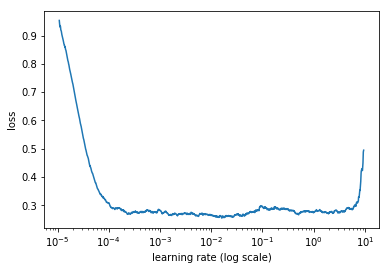

In [169]:
m.sched.plot(10)

In [170]:
lr = 1e-4

In [171]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                                 
    0      0.262194   0.250294  
    1      0.259055   0.24863                                  
    2      0.249345   0.246185                                 
    3      0.250215   0.245593                                 



[array([0.24559])]

In [172]:
m.fit(lr/5, 1, cycle_len=2)

epoch      trn_loss   val_loss                                 
    0      0.259097   0.245446  
    1      0.244063   0.245391                                 



[array([0.24539])]

In [173]:
m.fit(lr/10, 2, cycle_len=2,best_save_name="best_home_default")

epoch      trn_loss   val_loss                                 
    0      0.247168   0.24531   
    1      0.243632   0.245287                                 
    2      0.247639   0.24517                                  
    3      0.252955   0.245156                                 



[array([0.24516])]

In [174]:
m.fit(lr/20, 2, cycle_len=2,best_save_name="best_home_default")

epoch      trn_loss   val_loss                                 
    0      0.247204   0.245123  
    1      0.247582   0.24511                                  
    2      0.247642   0.245067                                 
    3      0.25382    0.245054                                 



[array([0.24505])]

In [175]:
m.fit(lr/20, 4, cycle_len=3,best_save_name="best_home_default")

epoch      trn_loss   val_loss                                 
    0      0.249853   0.245018  
    1      0.257159   0.244989                                 
    2      0.244434   0.244978                                 
    3      0.247711   0.244938                                 
    4      0.245946   0.24493                                  
    5      0.249851   0.244922                                 
    6      0.24572    0.244881                                 
    7      0.259546   0.244858                                 
    8      0.24384    0.244851                                 
    9      0.255824   0.244826                                 
    10     0.245417   0.244772                                 
    11     0.245316   0.244769                                 



[array([0.24477])]

In [176]:
m.save('val2')

In [177]:
m.load('val2')

In [192]:
md.test_dl.

# Eval

In [178]:
x1,y1=m.predict_with_targs()

In [189]:
predict_with_targs??

In [179]:
pred_test=m.predict(True)

RuntimeError: running_mean should contain 142 elements not 140

In [ ]:
pred_test1=m.predict(True)

In [ ]:
len(pred_test1)

In [ ]:
len(application_test)

In [ ]:
np.exp(pred_test1)

In [180]:
# WHY EXP
pred_test = np.exp(pred_test)
pred_test

NameError: name 'pred_test' is not defined

In [181]:
pred_test[:,0]

NameError: name 'pred_test' is not defined

In [182]:
matplotlib.pyplot.hist(pred_test[:,0])

NameError: name 'pred_test' is not defined

In [165]:
pred_test[:,0]

array([0.96425, 0.8789 , 0.95256, 0.9622 , 0.85846, 0.95459, 0.96552, 0.95053, 0.97978, 0.94149, 0.95054,
       0.94184, 0.90681, 0.94133, 0.90499, 0.92551, 0.95651, 0.97197, 0.90848, 0.9375 , ..., 0.89601,
       0.90614, 0.93872, 0.95391, 0.96709, 0.91316, 0.9086 , 0.97563, 0.85183, 0.95885, 0.92604, 0.95045,
       0.97805, 0.94552, 0.94006, 0.95516, 0.88703, 0.96113, 0.9434 , 0.92314], dtype=float32)

In [111]:
data  = list(iter(md.test_dl))

In [186]:
application_test['TARGET']=pred_test[:,1]

In [187]:
csv_fn=f'{PATH}/tmp/sub.csv'

In [192]:
application_test['SK_ID_CURR'] = application_test['SK_ID_CURR'].astype(int)

In [193]:
application_test[['SK_ID_CURR','TARGET']].to_csv(csv_fn, index=False)

In [194]:
FileLink(csv_fn)

/home/cheeseblubber/workspace/competition/home-default-credit/data/tmp/sub.csv